# Spoken digit classifier

## Loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
#!cp '/content/drive/MyDrive/ML-Assign-4/Use_This_SoundData(Original 9 May).mat' data.mat
!cp '/content/drive/MyDrive/ML-Assign-4/SoundData(Version 3).mat' data.mat

## Exploring Data

In [3]:
#imports
import cv2
import tqdm
import random
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

import torch
import torch.nn.functional as F
from torch import nn, optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import librosa

def set_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True
  g = torch.Generator()
  g.manual_seed(seed)
  return g

In [4]:
#load data
mat_file = loadmat('data.mat')
X_train = mat_file['XTrain']
X_test = mat_file['XTest']
Y_train = mat_file['YTrain']
Y_test = mat_file['YTest']
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(1600, 50, 500) (1600, 1) (400, 50, 500) (400, 1)


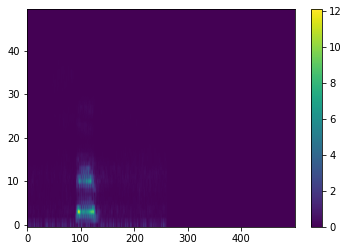

In [5]:
#plot a sample
x = X_train[5].copy()
x = np.sqrt(x.real**2 + x.imag**2)
plt.imshow(x, origin='lower', aspect="auto");
plt.colorbar();

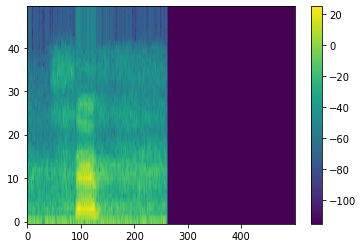

In [6]:
#plot a sample (in log-scale)
x = X_train[5].copy()
x[x==0] = 1e-5
x = 10*np.log( np.sqrt(x.real**2 + x.imag**2))
plt.imshow(x, origin='lower', aspect="auto");
plt.colorbar();

## Training Resnet

In [ ]:
!git clone https://github.com/Lornatang/ResNet-PyTorch.git
%cd /content/ResNet-PyTorch
from resnet_pytorch import ResNet 
model = ResNet.from_name("resnet18")
%cd /content/

In [8]:
#defining data class
class data_set(Dataset):
    def __init__(self,test=False):
              #load data
        mat_file = loadmat('data.mat')
        if test:
          self.specs = mat_file['XTest']
          self.labels =  mat_file['YTest']
        else:
          self.specs = mat_file['XTrain']
          self.labels = mat_file['YTrain']
        self.labels = self.labels.reshape(-1)

    def __len__(self):
        return len(self.labels)
  
    def __getitem__(self, index):
        spec = self.specs[index]
        r = spec.real
        i = spec.imag
        mag = np.sqrt(r**2 + i**2)
        spec = np.array([r,i,mag])

        label = self.labels[index]
        return spec,label

In [9]:
#training
#hyper-parameters values
g = set_seed(0)

num_epochs = 50
lr = 0.01
weight_decay = 5e-4
batch_size = 64

#dataloader, optimizer, scheduler, cost function
if torch.cuda.is_available():
  model = model.cuda()
optimizer = optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 3,factor=0.5)

DataSet = data_set()
train_DataSet, val_DataSet = random_split(DataSet,[1200,400])
train_loader = DataLoader(train_DataSet, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)
val_loader = DataLoader(val_DataSet, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)

loss_fn = nn.CrossEntropyLoss()

#training loop
train_loss_epochs = []
val_loss_epochs = []

for epoch in range(0,num_epochs):
  print('-'*10,f"Epoch :{epoch+1}/{num_epochs}",'-'*10)
  print('learning rate: ',optimizer.param_groups[0]["lr"])
  #train
  losses=[]
  model.train()
  for imgs,labels in train_loader:
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #forward
    preds = model(imgs.float())
    #loss and backward
    optimizer.zero_grad()
    loss = loss_fn(preds,labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().cpu())
  print('train loss: ',np.mean(losses))
  train_loss_epochs.append(np.mean(losses))

  #validation
  val_losses=[]
  model.eval()
  for imgs,labels in val_loader:
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    preds = model(imgs.float())
    val_loss = loss_fn(preds,labels)
    val_losses.append(val_loss.detach().cpu())
  scheduler.step(np.mean(val_losses))
  print('validation loss: ',np.mean(val_losses))
  val_loss_epochs.append(np.mean(val_losses))


---------- Epoch :1/50 ----------
learning rate:  0.01
train loss:  2.7274418
validation loss:  2.2801664
---------- Epoch :2/50 ----------
learning rate:  0.01
train loss:  1.9015002
validation loss:  2.3589528
---------- Epoch :3/50 ----------
learning rate:  0.01
train loss:  1.5271626
validation loss:  3.3793576
---------- Epoch :4/50 ----------
learning rate:  0.01
train loss:  1.2508124
validation loss:  2.6647656
---------- Epoch :5/50 ----------
learning rate:  0.01
train loss:  0.8157803
validation loss:  2.9239266
---------- Epoch :6/50 ----------
learning rate:  0.005
train loss:  0.45252478
validation loss:  0.8890636
---------- Epoch :7/50 ----------
learning rate:  0.005
train loss:  0.36229676
validation loss:  2.4139922
---------- Epoch :8/50 ----------
learning rate:  0.005
train loss:  0.24224904
validation loss:  1.0877011
---------- Epoch :9/50 ----------
learning rate:  0.005
train loss:  0.21358193
validation loss:  3.635669
---------- Epoch :10/50 ----------
lear

In [10]:
#tesing
test_DataSet = data_set(test=True)
test_len_data = test_DataSet.__len__()
test_loader = DataLoader(test_DataSet, batch_size=batch_size, shuffle=True)

model.eval()
true_preds_tot = 0
for imgs,labels in test_loader:
  if torch.cuda.is_available():
    imgs = imgs.cuda()
    labels = labels.cuda()
  preds = model(imgs.float())
  true_preds = (torch.max(preds,axis=1).indices == labels).sum()
  true_preds_tot += true_preds
print('test accuracy: ',100*(true_preds_tot.cpu().numpy()/test_len_data),'%')

test accuracy:  91.25 %


## Training Resnet pretrained with imagenet 

In [11]:
model = ResNet.from_pretrained('resnet18', num_classes=10)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Loaded pretrained weights for resnet18.


In [12]:
#training
#hyper-parameters values
g = set_seed(0)

num_epochs = 50
lr = 0.01
weight_decay = 5e-4
batch_size = 64

#dataloader, optimizer, scheduler, cost function
if torch.cuda.is_available():
  model = model.cuda()
optimizer = optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 3,factor=0.5)

DataSet = data_set()
train_DataSet, val_DataSet = random_split(DataSet,[1200,400])
train_loader = DataLoader(train_DataSet, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)
val_loader = DataLoader(val_DataSet, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)

loss_fn = nn.CrossEntropyLoss()

#training loop
train_loss_epochs = []
val_loss_epochs = []

for epoch in range(0,num_epochs):
  print('-'*10,f"Epoch :{epoch+1}/{num_epochs}",'-'*10)
  print('learning rate: ',optimizer.param_groups[0]["lr"])
  #train
  losses=[]
  model.train()
  for imgs,labels in train_loader:
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #forward
    preds = model(imgs.float())
    #loss and backward
    optimizer.zero_grad()
    loss = loss_fn(preds,labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().cpu())
  print('train loss: ',np.mean(losses))
  train_loss_epochs.append(np.mean(losses))

  #validation
  val_losses=[]
  model.eval()
  for imgs,labels in val_loader:
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    preds = model(imgs.float())
    val_loss = loss_fn(preds,labels)
    val_losses.append(val_loss.detach().cpu())
  scheduler.step(np.mean(val_losses))
  print('validation loss: ',np.mean(val_losses))
  val_loss_epochs.append(np.mean(val_losses))


---------- Epoch :1/50 ----------
learning rate:  0.01
train loss:  2.6297293
validation loss:  142.53304
---------- Epoch :2/50 ----------
learning rate:  0.01
train loss:  2.196549
validation loss:  2.023115
---------- Epoch :3/50 ----------
learning rate:  0.01
train loss:  1.728941
validation loss:  2.353832
---------- Epoch :4/50 ----------
learning rate:  0.01
train loss:  1.588786
validation loss:  2.3029602
---------- Epoch :5/50 ----------
learning rate:  0.01
train loss:  1.3037012
validation loss:  2.5280704
---------- Epoch :6/50 ----------
learning rate:  0.01
train loss:  1.2039341
validation loss:  1.3014474
---------- Epoch :7/50 ----------
learning rate:  0.01
train loss:  1.0733734
validation loss:  1.8707169
---------- Epoch :8/50 ----------
learning rate:  0.01
train loss:  0.61415356
validation loss:  1.680304
---------- Epoch :9/50 ----------
learning rate:  0.01
train loss:  0.40409568
validation loss:  2.0718484
---------- Epoch :10/50 ----------
learning rate: 

In [13]:
#tesing
test_DataSet = data_set(test=True)
test_len_data = test_DataSet.__len__()
test_loader = DataLoader(test_DataSet, batch_size=batch_size, shuffle=True)

model.eval()
true_preds_tot = 0
for imgs,labels in test_loader:
  if torch.cuda.is_available():
    imgs = imgs.cuda()
    labels = labels.cuda()
  preds = model(imgs.float())
  true_preds = (torch.max(preds,axis=1).indices == labels).sum()
  true_preds_tot += true_preds
print('test accuracy: ',100*(true_preds_tot.cpu().numpy()/test_len_data),'%')

test accuracy:  90.75 %


## Training with logscaled features

In [14]:
model = ResNet.from_pretrained('resnet18', num_classes=10)

Loaded pretrained weights for resnet18.


In [15]:
#defining data class
class data_set(Dataset):
    def __init__(self,test=False):
              #load data
        mat_file = loadmat('data.mat')
        if test:
          self.specs = mat_file['XTest']
          self.labels =  mat_file['YTest']
        else:
          self.specs = mat_file['XTrain']
          self.labels = mat_file['YTrain']
        self.labels = self.labels.reshape(-1)

    def __len__(self):
        return len(self.labels)
  
    def __getitem__(self, index):
        spec = self.specs[index]
        r = spec.real
        i = spec.imag
        mag = np.sqrt(r**2 + i**2)

        #logscale
        spec = np.array([r,i,mag])
        spec[spec==0] = 0.00000001
        spec = np.log(abs(spec))

        label = self.labels[index]
        return spec,label

In [16]:
#training
#hyper-parameters values
g = set_seed(0)

num_epochs = 50
lr = 0.01
weight_decay = 5e-4
batch_size = 64

#dataloader, optimizer, scheduler, cost function
if torch.cuda.is_available():
  model = model.cuda()
optimizer = optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 3,factor=0.5)

DataSet = data_set()
train_DataSet, val_DataSet = random_split(DataSet,[1200,400])
train_loader = DataLoader(train_DataSet, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)
val_loader = DataLoader(val_DataSet, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)

loss_fn = nn.CrossEntropyLoss()

#training loop
train_loss_epochs = []
val_loss_epochs = []

for epoch in range(0,num_epochs):
  print('-'*10,f"Epoch :{epoch+1}/{num_epochs}",'-'*10)
  print('learning rate: ',optimizer.param_groups[0]["lr"])
  #train
  losses=[]
  model.train()
  for imgs,labels in train_loader:
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #forward
    preds = model(imgs.float())
    #loss and backward
    optimizer.zero_grad()
    loss = loss_fn(preds,labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().cpu())
  print('train loss: ',np.mean(losses))
  train_loss_epochs.append(np.mean(losses))

  #validation
  val_losses=[]
  model.eval()
  for imgs,labels in val_loader:
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    preds = model(imgs.float())
    val_loss = loss_fn(preds,labels)
    val_losses.append(val_loss.detach().cpu())
  scheduler.step(np.mean(val_losses))
  print('validation loss: ',np.mean(val_losses))
  val_loss_epochs.append(np.mean(val_losses))


---------- Epoch :1/50 ----------
learning rate:  0.01
train loss:  2.9633086
validation loss:  477.24023
---------- Epoch :2/50 ----------
learning rate:  0.01
train loss:  2.422244
validation loss:  2.3637671
---------- Epoch :3/50 ----------
learning rate:  0.01
train loss:  2.3916252
validation loss:  2.3464715
---------- Epoch :4/50 ----------
learning rate:  0.01
train loss:  2.362701
validation loss:  2.354355
---------- Epoch :5/50 ----------
learning rate:  0.01
train loss:  2.2031217
validation loss:  14.835204
---------- Epoch :6/50 ----------
learning rate:  0.01
train loss:  1.9140263
validation loss:  20.96697
---------- Epoch :7/50 ----------
learning rate:  0.01
train loss:  1.714437
validation loss:  7.7559676
---------- Epoch :8/50 ----------
learning rate:  0.005
train loss:  1.254245
validation loss:  2.4559863
---------- Epoch :9/50 ----------
learning rate:  0.005
train loss:  0.9989515
validation loss:  4.208826
---------- Epoch :10/50 ----------
learning rate:  

In [17]:
#tesing
test_DataSet = data_set(test=True)
test_len_data = test_DataSet.__len__()
test_loader = DataLoader(test_DataSet, batch_size=batch_size, shuffle=True)

model.eval()
true_preds_tot = 0
for imgs,labels in test_loader:
  if torch.cuda.is_available():
    imgs = imgs.cuda()
    labels = labels.cuda()
  preds = model(imgs.float())
  true_preds = (torch.max(preds,axis=1).indices == labels).sum()
  true_preds_tot += true_preds
print('test accuracy: ',100*(true_preds_tot.cpu().numpy()/test_len_data),'%')

test accuracy:  92.25 %


## Pretraining

### Convert audio mnist data to spectrograms

In [ ]:
!git clone https://github.com/soerenab/AudioMNIST

In [19]:
!mkdir soundfiles

In [20]:
sound_files = glob.glob('AudioMNIST/data/*/*')
for sound_file in tqdm.tqdm(sound_files):
    x, _ = librosa.load(sound_file, sr=44100)
    X = librosa.stft(x)
    r = cv2.resize(X.real,(500,50))
    i = cv2.resize(X.imag,(500,50))
    mag = np.sqrt(r**2 + i**2)
    spec = np.array([r,i,mag])
    np.save('soundfiles/'+sound_file.split('/')[-1].split('.')[0]+'.npy',spec)

100%|██████████| 30000/30000 [17:10<00:00, 29.11it/s]


In [21]:
len(glob.glob('/content/soundfiles/*'))

30000

### Training

In [22]:
specs = glob.glob('soundfiles/*')
sound_file =  specs[0]
spec = np.load(sound_file)
spec.shape

(3, 50, 500)

In [23]:
#defining data class for pretraining data
class data_set_pt(Dataset):
    def __init__(self,test=False):
        self.specs = glob.glob('soundfiles/*')
        self.labels = [int(l.split('/')[-1].split('_')[0]) for l in self.specs]

    def __len__(self):
        return len(self.specs)
  
    def __getitem__(self, index):
        sound_file =  self.specs[index]
        spec = np.load(sound_file)
        label = self.labels[index]
        return spec,label

In [24]:
#defining data class for training
class data_set(Dataset):
    def __init__(self,test=False):
              #load data
        mat_file = loadmat('data.mat')
        if test:
          self.specs = mat_file['XTest']
          self.labels =  mat_file['YTest']
        else:
          self.specs = mat_file['XTrain']
          self.labels = mat_file['YTrain']
        self.labels = self.labels.reshape(-1)

    def __len__(self):
        return len(self.labels)
  
    def __getitem__(self, index):
        spec = self.specs[index]
        r = spec.real
        i = spec.imag
        mag = np.sqrt(r**2 + i**2)
        spec = np.array([r,i,mag])

        label = self.labels[index]
        return spec,label

In [25]:
model = ResNet.from_name("resnet18")

In [26]:
#pre-training
#hyper-parameters values
g = set_seed(0)

num_epochs = 10
lr = 0.01
weight_decay = 5e-4
batch_size = 512

#dataloader, optimizer, cost function
if torch.cuda.is_available():
  model = model.cuda()
optimizer = optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)

DataSet = data_set_pt()
train_loader = DataLoader(DataSet, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)

loss_fn = nn.CrossEntropyLoss()

#training loop
train_loss_epochs = []

for epoch in range(0,num_epochs):
  print('-'*10,f"Epoch :{epoch+1}/{num_epochs}",'-'*10)
  print('learning rate: ',optimizer.param_groups[0]["lr"])
  #train
  losses=[]
  model.train()
  for imgs,labels in tqdm.tqdm(train_loader):
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #forward
    preds = model(imgs.float())
    #loss and backward
    optimizer.zero_grad()
    loss = loss_fn(preds,labels)
    loss.backward()
    optimizer.step()
    #losses.append(loss.detach().cpu())
  print('train loss: ',loss.detach().cpu())
  #train_loss_epochs.append(np.mean(losses))
    

---------- Epoch :1/10 ----------
learning rate:  0.01


100%|██████████| 58/58 [01:32<00:00,  1.59s/it]


train loss:  tensor(0.2369)
---------- Epoch :2/10 ----------
learning rate:  0.01


100%|██████████| 58/58 [01:27<00:00,  1.51s/it]


train loss:  tensor(0.1952)
---------- Epoch :3/10 ----------
learning rate:  0.01


100%|██████████| 58/58 [01:30<00:00,  1.55s/it]


train loss:  tensor(0.2005)
---------- Epoch :4/10 ----------
learning rate:  0.01


100%|██████████| 58/58 [01:29<00:00,  1.54s/it]


train loss:  tensor(0.1072)
---------- Epoch :5/10 ----------
learning rate:  0.01


100%|██████████| 58/58 [01:57<00:00,  2.03s/it]


train loss:  tensor(0.1094)
---------- Epoch :6/10 ----------
learning rate:  0.01


100%|██████████| 58/58 [03:53<00:00,  4.02s/it]


train loss:  tensor(0.0791)
---------- Epoch :7/10 ----------
learning rate:  0.01


100%|██████████| 58/58 [03:53<00:00,  4.03s/it]


train loss:  tensor(0.0806)
---------- Epoch :8/10 ----------
learning rate:  0.01


100%|██████████| 58/58 [03:52<00:00,  4.01s/it]


train loss:  tensor(0.0557)
---------- Epoch :9/10 ----------
learning rate:  0.01


100%|██████████| 58/58 [03:53<00:00,  4.02s/it]


train loss:  tensor(0.0659)
---------- Epoch :10/10 ----------
learning rate:  0.01


100%|██████████| 58/58 [03:54<00:00,  4.04s/it]


train loss:  tensor(0.0394)


In [27]:
#training
#hyper-parameters values
g = set_seed(0)

num_epochs = 50
lr = 0.01
weight_decay = 5e-4
batch_size = 64

#dataloader, optimizer, scheduler, cost function
if torch.cuda.is_available():
  model = model.cuda()
optimizer = optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 3,factor=0.5)

DataSet = data_set()
train_DataSet, val_DataSet = random_split(DataSet,[1200,400])
train_loader = DataLoader(train_DataSet, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)
val_loader = DataLoader(val_DataSet, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)

loss_fn = nn.CrossEntropyLoss()

#training loop
train_loss_epochs = []
val_loss_epochs = []

for epoch in range(0,num_epochs):
  print('-'*10,f"Epoch :{epoch+1}/{num_epochs}",'-'*10)
  print('learning rate: ',optimizer.param_groups[0]["lr"])
  #train
  losses=[]
  model.train()
  for imgs,labels in train_loader:
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #forward
    preds = model(imgs.float())
    #loss and backward
    optimizer.zero_grad()
    loss = loss_fn(preds,labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().cpu())
  print('train loss: ',np.mean(losses))
  train_loss_epochs.append(np.mean(losses))

  #validation
  val_losses=[]
  model.eval()
  for imgs,labels in val_loader:
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    preds = model(imgs.float())
    val_loss = loss_fn(preds,labels)
    val_losses.append(val_loss.detach().cpu())
  scheduler.step(np.mean(val_losses))
  print('validation loss: ',np.mean(val_losses))
  val_loss_epochs.append(np.mean(val_losses))


---------- Epoch :1/50 ----------
learning rate:  0.01
train loss:  2.5329072
validation loss:  3.4741452
---------- Epoch :2/50 ----------
learning rate:  0.01
train loss:  1.2830384
validation loss:  3.1942587
---------- Epoch :3/50 ----------
learning rate:  0.01
train loss:  0.7597837
validation loss:  1.5310497
---------- Epoch :4/50 ----------
learning rate:  0.01
train loss:  0.42949662
validation loss:  1.2706457
---------- Epoch :5/50 ----------
learning rate:  0.01
train loss:  0.25597224
validation loss:  0.508007
---------- Epoch :6/50 ----------
learning rate:  0.01
train loss:  0.31020403
validation loss:  0.96287376
---------- Epoch :7/50 ----------
learning rate:  0.01
train loss:  0.2208021
validation loss:  0.9661834
---------- Epoch :8/50 ----------
learning rate:  0.01
train loss:  0.1005302
validation loss:  0.41718897
---------- Epoch :9/50 ----------
learning rate:  0.01
train loss:  0.11656577
validation loss:  0.409641
---------- Epoch :10/50 ----------
learnin

In [28]:
#tesing
test_DataSet = data_set(test=True)
test_len_data = test_DataSet.__len__()
test_loader = DataLoader(test_DataSet, batch_size=batch_size, shuffle=True)

model.eval()
true_preds_tot = 0
for imgs,labels in test_loader:
  if torch.cuda.is_available():
    imgs = imgs.cuda()
    labels = labels.cuda()
  preds = model(imgs.float())
  true_preds = (torch.max(preds,axis=1).indices == labels).sum()
  true_preds_tot += true_preds
print('test accuracy: ',100*(true_preds_tot.cpu().numpy()/test_len_data),'%')

test accuracy:  91.5 %
